<a href="https://colab.research.google.com/github/EliasSf73/Data-Science/blob/main/Copy_of_EKAI_Notebook_Dense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='1'></a>
# Prepare packages and data


In [ ]:
!git clone https://github.com/linq-rag/FinanceRAG.git
!pip -q install datasets
!pip -q install gdown
!pip -q install chromadb
!pip -q install accelerate
!pip -q install openai
!pip -q install pytrec_eval
!pip -q install rank_bm25
!pip -q install xformers

Cloning into 'FinanceRAG'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 57 (delta 2), reused 2 (delta 2), pack-reused 53 (from 1)
Receiving objects: 100% (57/57), 31.80 KiB | 1.45 MiB/s, done.
Resolving deltas: 100% (12/12), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompa

In [ ]:
%cd FinanceRAG

/content/FinanceRAG


In [ ]:
# Data download
import gdown
gdown.download(f'https://drive.google.com/uc?id=1i774wMDNU1GI_jgHgYpWlY7lnsvbljDO', './gt.zip', quiet=False)
!unzip gt.zip -d /content/gt

Downloading...
From: https://drive.google.com/uc?id=1i774wMDNU1GI_jgHgYpWlY7lnsvbljDO
To: /content/FinanceRAG/gt.zip
100%|██████████| 15.1k/15.1k [00:00<00:00, 13.5MB/s]

Archive:  gt.zip
  inflating: /content/gt/TATQA_qrels.tsv  
  inflating: /content/gt/ConvFinQA_qrels.tsv  
  inflating: /content/gt/MultiHiertt_qrels.tsv  
  inflating: /content/gt/FinanceBench_qrels.tsv  
  inflating: /content/gt/FinDER_qrels.tsv  
  inflating: /content/gt/FinQABench_qrels.tsv  
  inflating: /content/gt/FinQA_qrels.tsv  


In [ ]:
# Import required libraries for document retrieval
import os
import torch
from financerag.tasks import FinDER, TATQA, FinQABench, FinanceBench, FinQA, ConvFinQA, MultiHiertt
from financerag.common import CrossEncoder, Encoder, Lexical, Retrieval
from rank_bm25 import BM25Okapi
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
import numpy as np
import chromadb
import pandas as pd

from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore")

<a id='2'></a>
# About Tasks

As you know, the competition provides an integrated dataset of text and table-formatted financial information, designed to test the system's ability to retrieve and reason with financial data. Here is a brief description of seven datasets.


### Task Type: Passage Retrieval:
- FinDER: This task involves retrieving relevant sections from 10-K reports and financial disclosures based on search queries that mimic real questions posed by financial experts. It incorporates domain-specific terms and abbreviations.
- FinQABench: This benchmark tests the performance of AI models in answering queries about 10-K reports, evaluating their ability to detect misinformation and maintain factual accuracy.
- FinanceBench: This task involves using natural language queries to retrieve relevant information from publicly available documents, such as 10-K and annual reports, assessing how well systems handle realistic financial questions.


### Task Type: Tabular and Text Retrieval:
- TATQA: This task requires answering natural language queries that demand numerical reasoning based on data combined from tables and text in financial reports. It includes basic arithmetic, comparisons, and logical reasoning.
- FinQA: This challenge involves answering complex natural language queries in financial reports through multi-step numerical reasoning, requiring precise extraction and calculation from both text and table data.
- ConvFinQA: This task involves responding to queries through multiple conversational turns in financial reports, maintaining accurate context across turns to provide precise answers.
- MultiHiertt: This task requires multi-step query resolution based on hierarchical tables and unstructured.

## Analyze Each Dataset

1. FinDER() - Corresponds to the to the `finder_corpus.jsonl` and `finder_queries.jsonl` folders. The same goes for the rest of the folders. Each of them have their own tasks.

In [ ]:
# It is possible to easily load data using the financerag library.
# For tutorial, we will use the FinDER datasets, one of the available tasks in FinanceRAG.
finder_task = FinDER()

README.md:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/858 [00:00<?, ?B/s]

corpus.jsonl.gz:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

queries.jsonl.gz:   0%|          | 0.00/4.91k [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/13867 [00:00<?, ? examples/s]

Generating queries split:   0%|          | 0/216 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/13867 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/216 [00:00<?, ? examples/s]

In [ ]:
# .corpus attribute contains the list of documents

document_list_finder = finder_task.corpus

print(f"Number of documents: {len(document_list_finder)}")
print(f"document 1: {document_list_finder[list(document_list_finder.keys())[0]]}")

# .queries attribute contains the list of queries

query_list_finder = finder_task.queries

print(f"Number of queries: {len(query_list_finder)}")
print(f"query 1: {query_list_finder[list(query_list_finder.keys())[0]]}")

Number of documents: 13863
document 1: {'title': 'ADBE OVERVIEW', 'text': 'Adobe is a global technology company with a mission to change the world through personalized digital experiences. For over four decades, Adobe’s innovations have transformed how individuals, teams, businesses, enterprises, institutions, and governments engage and interact across all types of media. Our products, services and solutions are used around the world to imagine, create, manage, deliver, measure, optimize and engage with content across surfaces and fuel digital experiences. We have a diverse user base that includes consumers, communicators, creative professionals, developers, students, small and medium businesses and enterprises. We are also empowering creators by putting the power of artificial intelligence (“AI”) in their hands, and doing so in ways we believe are responsible. Our products and services help unleash creativity, accelerate document productivity and power businesses in a digital world.'}

In [ ]:
# let's see it in detail
# document_list_finder, is a dictionary, whose
# keys => the corpus_ids belonging to the dataset: "finder_corpus.jsonl/corpus.jsonl"
# values => the remaining dictionary: {title: "title_name", text: "entire_corpus_text"}
first_corpus_dict = document_list_finder['AAPL20230004']
first_corpus_dict

{'title': 'AAPL Company Background',
 'text': 'The Company designs, manufactures and markets smartphones, personal computers, tablets, wearables and accessories, and sells a variety of related services. The Company’s fiscal year is the 52- or 53-week period that ends on the last Saturday of September.'}

In [ ]:
# we can iterate as follows:
# iterate through the first "k" corpuses
k = 5
for i, corpuse_id in enumerate(document_list_finder):
  print('Document', i+1)
  print("Corpus ID:", corpuse_id)
  print('Title:', document_list_finder[corpuse_id]["title"])
  print('text:', document_list_finder[corpuse_id]["text"].replace('.', '.\n'))
  print()
  if i > k - 2:
    break

Document 1
Corpus ID: ADBE20230004
Title: ADBE OVERVIEW
text: Adobe is a global technology company with a mission to change the world through personalized digital experiences.
 For over four decades, Adobe’s innovations have transformed how individuals, teams, businesses, enterprises, institutions, and governments engage and interact across all types of media.
 Our products, services and solutions are used around the world to imagine, create, manage, deliver, measure, optimize and engage with content across surfaces and fuel digital experiences.
 We have a diverse user base that includes consumers, communicators, creative professionals, developers, students, small and medium businesses and enterprises.
 We are also empowering creators by putting the power of artificial intelligence (“AI”) in their hands, and doing so in ways we believe are responsible.
 Our products and services help unleash creativity, accelerate document productivity and power businesses in a digital world.


Documen

In financial data, it is common to encounter a mix of tables and text. These table data are often represented as text (strings) in Markdown format. So, how to effectively handle table data could be an important consideration.

In [ ]:
# This is a example of table data in the TATQA dataset
tatqa_task = TATQA()
document_list_tatqa = tatqa_task.corpus

print(f"\nTable Example:\n\n {document_list_tatqa[list(document_list_tatqa.keys())[0]]['text']}")

corpus.jsonl.gz:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

queries.jsonl.gz:   0%|          | 0.00/36.9k [00:00<?, ?B/s]

Generating corpus split:   0%|          | 0/2756 [00:00<?, ? examples/s]

Generating queries split:   0%|          | 0/1663 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2756 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1663 [00:00<?, ? examples/s]


Table Example:

 The following tables present the recorded investment by portfolio segment and by class, excluding commercial financing receivables and other miscellaneous financing receivables at December 31, 2019 and 2018. Commercial financing receivables are excluded from the presentation of financing receivables by portfolio segment, as they are short term in nature and the current estimated risk of loss and resulting impact to the company’s financing results are not material.
Write-offs of lease receivables and loan receivables were $16 million and $47 million, respectively, for the year ended December 31, 2019. Provisions for credit losses recorded for lease receivables and loan receivables were a release of $6 million and an addition of $2 million, respectively, for the year ended December 31, 2019.
The average recorded investment of impaired leases and loans for Americas, EMEA and Asia Pacific was $138 million, $49 million and $45 million, respectively, for the year ended Dece

In [ ]:
# Let's iterate through 2 of the tables as follows:
# iterate through the first "k" corpuses
k = 2
for i, corpuse_id in enumerate(document_list_tatqa):
  print('Table', i+1)
  print('#'*100)
  print("Corpus ID:", corpuse_id)
  print('Title:', document_list_tatqa[corpuse_id]["title"])
  print('text:', document_list_tatqa[corpuse_id]["text"])
  print()
  if i > k - 2:
    break

Table 1
####################################################################################################
Corpus ID: d1b2e74c0
Title: 
text: The following tables present the recorded investment by portfolio segment and by class, excluding commercial financing receivables and other miscellaneous financing receivables at December 31, 2019 and 2018. Commercial financing receivables are excluded from the presentation of financing receivables by portfolio segment, as they are short term in nature and the current estimated risk of loss and resulting impact to the company’s financing results are not material.
Write-offs of lease receivables and loan receivables were $16 million and $47 million, respectively, for the year ended December 31, 2019. Provisions for credit losses recorded for lease receivables and loan receivables were a release of $6 million and an addition of $2 million, respectively, for the year ended December 31, 2019.
The average recorded investment of impaired leases and 

<a id='3'></a>
# Step 1. Data Chunking

In [ ]:
# Install NLTK punkt tokenizer if not already downloaded
nltk.download('punkt')

In [ ]:
# Document Example

example = \
"""Adobe is a global technology company with a mission to change the world through personalized digital experiences.
For over four decades, Adobe’s innovations have transformed how individuals, teams, businesses, enterprises, institutions, and governments engage and interact across all types of media.
Our products, services and solutions are used around the world to imagine, create, manage, deliver, measure, optimize and engage with content across surfaces and fuel digital experiences.
We have a diverse user base that includes consumers, communicators, creative professionals, developers, students, small and medium businesses and enterprises.
We are also empowering creators by putting the power of artificial intelligence (“AI”) in their hands, and doing so in ways we believe are responsible.
Our products and services help unleash creativity, accelerate document productivity and power businesses in a digital world."""

chunk_size = 64

# fixed length chunking
chunks_fixed = []

for i in range(0, len(example), chunk_size):
    chunks_fixed.append(example[i:i+chunk_size])

# You can see the chunks of the document, but some text is truncated since the chunk size is fixed
# e.g the sentence is truncated in the middle
print(f"Fixed Length Chunks 1: \n{chunks_fixed[0]}")

print(f"Fixed Length Chunks 2: \n{chunks_fixed[1]}")


In [ ]:
# sentence-level chunking
chunks_sent = nltk.sent_tokenize(example)

# You can see the entire sentence in the chunks and the sentence is not truncated
# But this chunk size may be too small for some cases
print(f"Sentence Level Chunks: \n{chunks_sent[0]}")

In [ ]:
# Overlap chunking
chunks_overlap = []

overlap_size = 32

for start in range(0, len(example), chunk_size):
    end = start + chunk_size
    if start == 0:
        chunk = example[start:end+overlap_size]
    else:
        chunk = example[start-overlap_size:end+overlap_size]
    if len(chunk) > 0:
        chunks_overlap.append(chunk)

# the overlap chunking allows for more context (including prior and post context) to be included in the chunks
# compare this to the fixed length chunking
print(f"Overlap Chunks\n\n")

print(f"Overlap Chunks 1: \n{chunks_overlap[0]}")
print(f"Overlap Chunks 2: \n{chunks_overlap[1]}")

print("-"*100)
print(f"Fixed Length Chunks\n\n")

print(f"Fixed Length Chunks 1: \n{chunks_fixed[0]}")
print(f"Fixed Length Chunks 2: \n{chunks_fixed[1]}")



In competitions datasets, since the documents are already chunked in the data, there is no need to perform chunking again. However, re-chunking and applying post-processing (doc ID matching) later could be a good strategy for better retrieval performance.

we will introduce advanced methods this Thursday, so try other chunking methods yourself.

<a id='4'></a>
# Step 2. Chunk Embedding

For chunk embedding, it is necessary to aggregate token-level embeddings into a fixed-size vector to represent a document, sentence, or query. This process is known as "pooling". There are two commonly used pooling strategies:

- reference : https://blog.ml6.eu/the-art-of-pooling-embeddings-c56575114cf8

1. CLS Token Pooling:

- Utilizes the [CLS] token embedding (commonly used in transformer-based models like BERT) as the representation of the entire input.
- The [CLS] token is pretrained to summarize the input during the model's training phase.
- Provides a concise and often effective representation of the sequence, especially for tasks like retrieval.

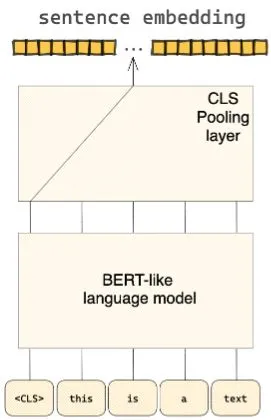

2. Mean Pooling:
- Aggregates embeddings by averaging the token-level vectors across all tokens.
- Simple and efficient, making it a widely used choice.
- Works well when all tokens contribute equally to the semantic meaning of the input.

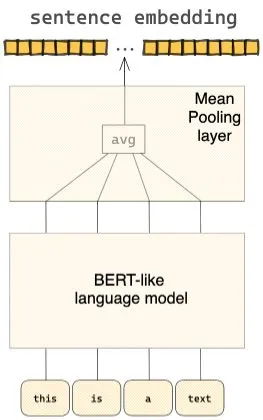

As discussed in the class, there are benchmarks available for text embedding models; however, due to the limitations of Google Colab, only lightweight models can be used. In the context of finance, where tables and structured data are often present, it is essential to consider various embedding models to handle these diverse data formats effectively.

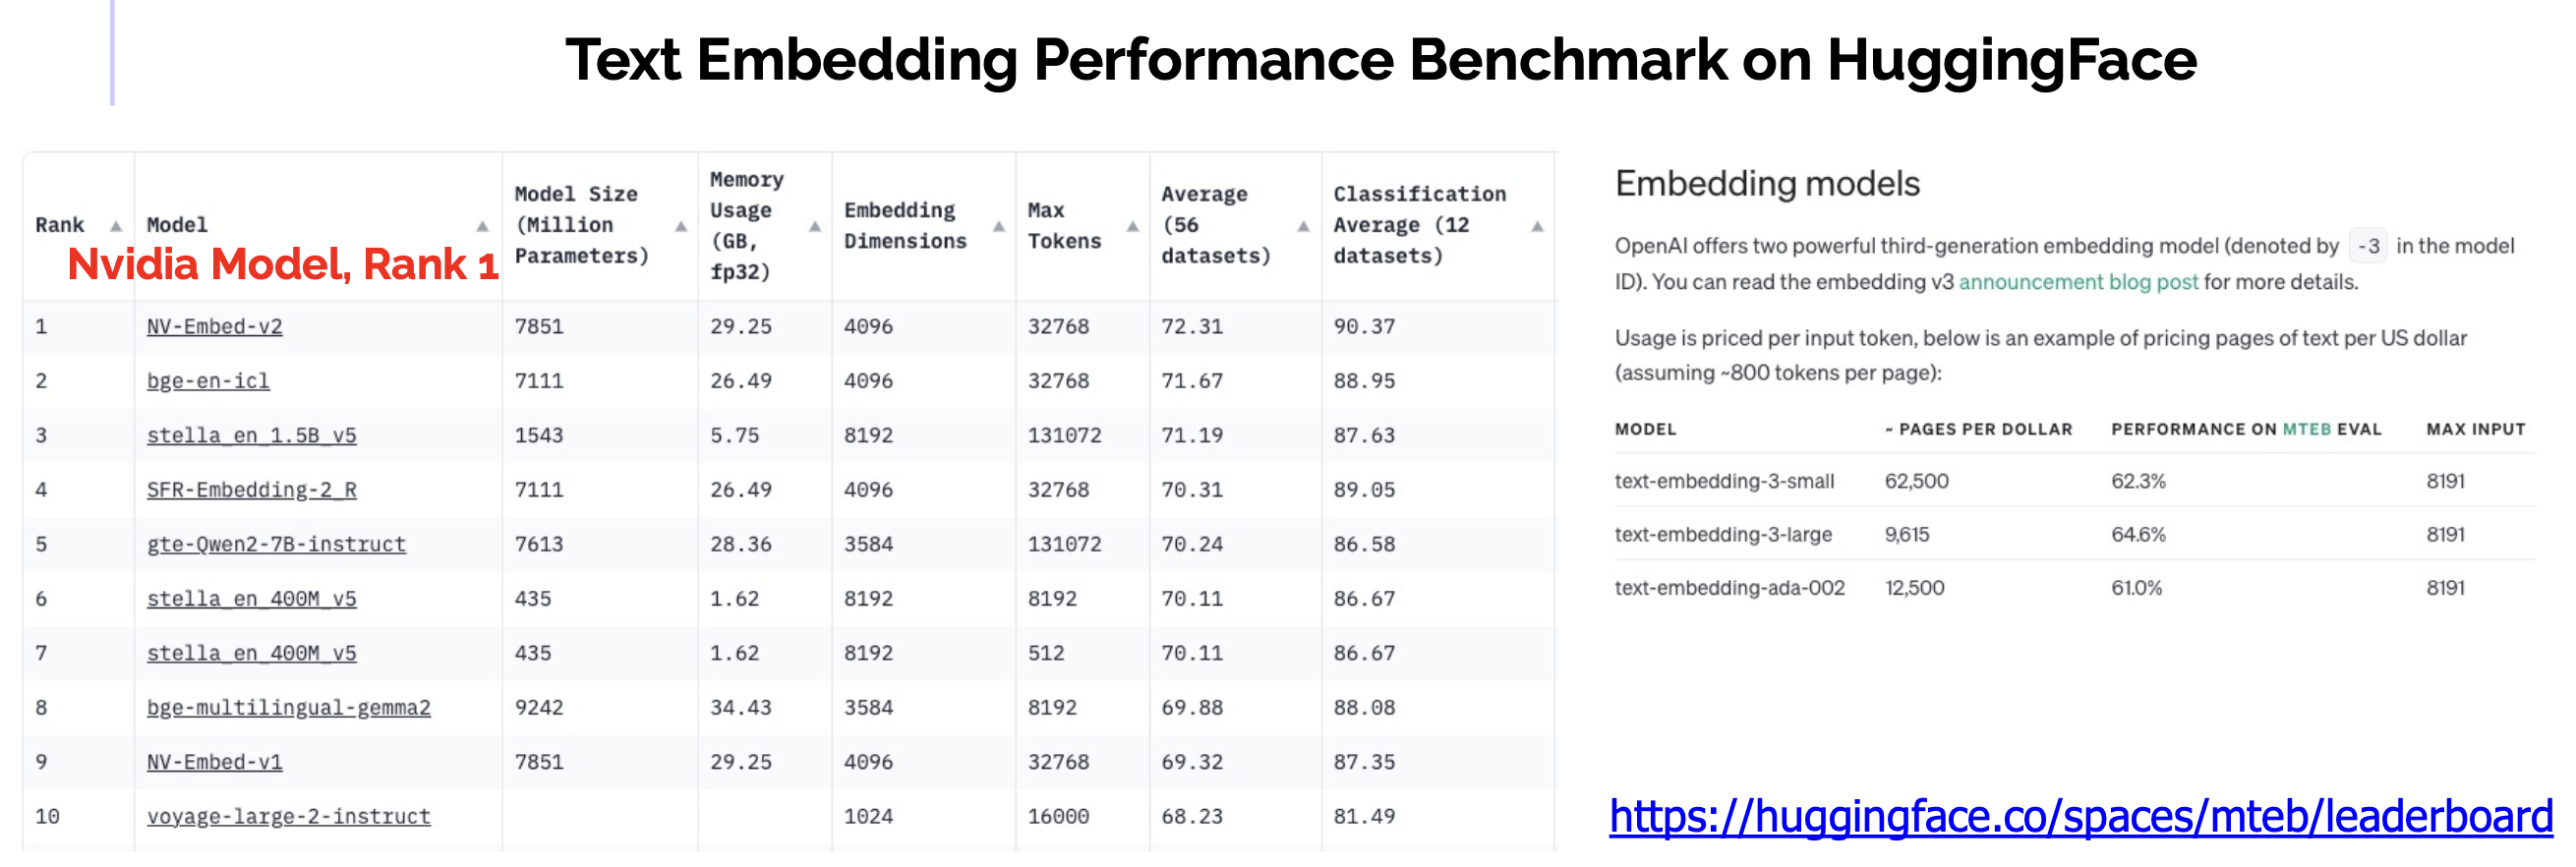

In [ ]:

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utill functions for dense retrieval
##################################################################################
def cos_sim(a, b):
    a = _ensure_tensor(a)
    b = _ensure_tensor(b)
    return torch.mm(
        torch.nn.functional.normalize(a, p=2, dim=1),
        torch.nn.functional.normalize(b, p=2, dim=1).transpose(0, 1),
    )

@torch.no_grad()
def dot_score(a, b):
    a = _ensure_tensor(a)
    b = _ensure_tensor(b)
    return torch.mm(a, b.transpose(0, 1))

def _ensure_tensor(x):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, device=device)
    if len(x.shape) == 1:
        x = x.unsqueeze(0)
    return x


# Mean pooling remains the same
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

##################################################################################

class TransformerEncoder(Encoder):
    def __init__(self, model_name_or_path, query_prompt=None, doc_prompt=None, **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True)
        self.encoder = AutoModel.from_pretrained(model_name_or_path, trust_remote_code=True).to(device)  # Load model to GPU

        self.query_prompt = query_prompt
        self.doc_prompt = doc_prompt

    def encode(self, texts, batch_size=8, use_mean_pooling=True):
        embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = self.tokenizer(
                batch_texts,
                return_tensors="pt",
                truncation=True,
                padding=True
            ).to(device)  # Move inputs to GPU
            with torch.no_grad():
                outputs = self.encoder(**inputs)
            if use_mean_pooling:
                # Apply mean pooling
                pooled_embeddings = mean_pooling(outputs, inputs['attention_mask'])
                embeddings.append(pooled_embeddings)
            else:
                # Use the [CLS] token's output for embeddings (first token representation)
                cls_embeddings = outputs.last_hidden_state[:, 0, :]
                embeddings.append(cls_embeddings)
        return torch.cat(embeddings, dim=0).cpu()  # Move back to CPU if needed

    def encode_queries(self, queries, batch_size=8, use_mean_pooling=True, **kwargs):
        if self.query_prompt is not None:
            queries = [self.query_prompt + query for query in queries]
        return self.encode(queries, batch_size=batch_size, use_mean_pooling=use_mean_pooling, **kwargs)

    def encode_corpus(self, corpus, batch_size=8, use_mean_pooling=True, **kwargs):
        if isinstance(corpus, dict):
            sentences = [
                (
                    (corpus["title"][i] + " " + corpus["text"][i]).strip()
                    if "title" in corpus
                    else corpus["text"][i].strip()
                )
                for i in range(len(corpus["text"]))
            ]
        else:
            sentences = [
                (
                    (doc["title"] + " " + doc["text"]).strip()
                    if "title" in doc
                    else doc["text"].strip()
                )
                for doc in corpus
            ]
        if self.doc_prompt is not None:
            sentences = [self.doc_prompt + s for s in sentences]
        return self.encode(sentences, batch_size=batch_size, use_mean_pooling=use_mean_pooling, **kwargs)


In [ ]:
# You can change the embedding model as needed
encoder_model = "dunzhang/stella_en_400M_v5"
encoder = TransformerEncoder(encoder_model)

# # Example of encoding the text
# query_embeddings = encoder.encode_corpus({"text": "What is Adobe's mission?"})

# query_embeddings

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

configuration.py:   0%|          | 0.00/7.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling.py:   0%|          | 0.00/57.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dunzhang/stella_en_400M_v5:
- modeling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xformers/__init__.py", line 57, in _is_triton_available
    import triton  # noqa
ModuleNotFoundError: No module named 'triton'


model.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<a id='5'></a>
# Step 3. Vector DB

It is efficient to vectorize the documents once and store them in a database for retrieval. As mentioned in the class, we can stores chunks in a Vector DB, enabling efficient retrieval. we show the example using Chroma DB, which is one of the most popular databases for this purpose.

In [ ]:

# You can use the following code to vectorize the documents and store them in a database for retrieval

# Vectorize the documents
encoder = TransformerEncoder(
    model_name_or_path='dunzhang/stella_en_400M_v5',
)

example_document = dict(list(document_list_finder.items())[:5])

# Initialize ChromaDB client
chroma_client = chromadb.Client()

# Create a collection to store embeddings
collection_name = "example_db"

chroma_collection = chroma_client.get_or_create_collection(name=collection_name)

# Prepare embeddings and associated metadata
for doc_id, document in example_document.items():
    chroma_collection.add(
        ids=[doc_id],
        documents=[document['text']],
    )
print(f"Document embeddings successfully stored in the '{collection_name}' collection.")


Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['new.pooler.dense.bias', 'new.pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:00<00:00, 89.1MiB/s]


Document embeddings successfully stored in the 'example_db' collection.


In [ ]:
# Retrieve the top 5 documents for the query
results = chroma_collection.query(
    query_texts=["What are the service and product offerings from Microsoft"], # Chroma will embed this for you
    n_results=5 # how many results to return
)
print(results)

{'ids': [['ADBE20230006', 'ADBE20230008', 'ADBE20230010', 'ADBE20230007', 'ADBE20230004']], 'embeddings': None, 'documents': [['We deliver a wide range of products, services and solutions to empower our customers and users to imagine and express ideas, create content and bring any digital experience to life. We focus our strategic investments in two areas of growth:', 'Digital Experience. We provide an integrated platform and set of products, services and solutions through Adobe Experience Cloud that enable businesses to create, manage, execute, measure, monetize and optimize customer experiences spanning from analytics to commerce. Our customers include marketers, advertisers, agencies, publishers, merchandisers, merchants, web analysts, data scientists, developers and executives across the C-suite. The foundation of our offering is Adobe Experience Platform, which provides businesses and brands with an open and extensible system for customer experience management that transforms cust

<a id='6'></a>
# Step 4. Retrieval

### Sparse Retrieval

In [ ]:

# Modify https://github.com/linq-rag/FinanceRAG/blob/main/financerag/retrieval/bm25.py
def tokenize_list(input_list):
    return list(map(word_tokenize, input_list))

class BM25Retriever(Retrieval):
    def __init__(self, model, tokenizer=tokenize_list):
        self.model = model
        self.tokenizer = tokenizer
        self.results = {}

    def retrieve(self, corpus, queries, top_k=None, score_function=None, return_sorted=False, **kwargs):

        query_ids = list(queries.keys())
        self.results = {qid: {} for qid in query_ids}
        query_lower_tokens = self.tokenizer([queries[qid].lower() for qid in queries])

        corpus_ids = list(corpus.keys())

        for qid, query in tqdm(zip(query_ids, query_lower_tokens)):
            scores = self.model.get_scores(query)
            top_k_result = np.argsort(scores)[::-1][:top_k]
            for idx in top_k_result:
                self.results[qid][corpus_ids[idx]] = scores[idx]

        return self.results



In [ ]:
from rank_bm25 import BM25Okapi
from tqdm import tqdm

# Tokenize the corpus (the subset of documents) and the queries
tokenized_corpus = tokenize_list([doc["title"].lower() + ' ' + doc["text"].lower() for doc in dict(list(document_list_finder.items())[:5]).values()])

# We can use the BM25Okapi from the rank_bm25 library for sparse retrieval
bm25 = BM25Okapi(tokenized_corpus)
retriever = BM25Retriever(bm25)

# Retrieve the top 5 documents for each query
retrieval_results = retriever.retrieve(corpus=dict(list(document_list_finder.items())[:5]), queries=dict(list(query_list_finder.items())[:5]), top_k=5)

# Print the retrieval results
for query_id, results in retrieval_results.items():
    print(f"Query ID: {query_id}")
    for doc_id, score in results.items():
        print(f"Document ID: {doc_id} | Score: {score}")
    print("\n")

5it [00:00, 878.17it/s]

Query ID: q00001
Document ID: ADBE20230004 | Score: 2.1940381667200435
Document ID: ADBE20230008 | Score: 1.7294313778458381
Document ID: ADBE20230007 | Score: 1.4883294014263155
Document ID: ADBE20230006 | Score: 0.5482318678744192
Document ID: ADBE20230010 | Score: 0.5425987148155678


Query ID: q00002
Document ID: ADBE20230007 | Score: 0.8809164290272405
Document ID: ADBE20230010 | Score: 0.0
Document ID: ADBE20230008 | Score: 0.0
Document ID: ADBE20230006 | Score: 0.0
Document ID: ADBE20230004 | Score: 0.0


Query ID: q00003
Document ID: ADBE20230004 | Score: 2.5160947132849465
Document ID: ADBE20230010 | Score: 0.22440861869951897
Document ID: ADBE20230006 | Score: 0.2168338809761948
Document ID: ADBE20230007 | Score: 0.19536542170855845
Document ID: ADBE20230008 | Score: 0.15129572696515894


Query ID: q00004
Document ID: ADBE20230007 | Score: 2.2269967557208403
Document ID: ADBE20230004 | Score: 1.0236350034507544
Document ID: ADBE20230010 | Score: 0.6024700125864423
Document ID

In [ ]:

# Show the top 5 documents for the first query
print("Query 1", query_list_finder[list(query_list_finder.keys())[0]])
print("\n")

for doc_id, score in retrieval_results[list(query_list_finder.keys())[0]].items():
    print(f"Document ID: {doc_id} | Document: {document_list_finder[doc_id]['text']} | Score: {score}")

Query 1 What are the service and product offerings from Microsoft


Document ID: ADBE20230004 | Document: Adobe is a global technology company with a mission to change the world through personalized digital experiences. For over four decades, Adobe’s innovations have transformed how individuals, teams, businesses, enterprises, institutions, and governments engage and interact across all types of media. Our products, services and solutions are used around the world to imagine, create, manage, deliver, measure, optimize and engage with content across surfaces and fuel digital experiences. We have a diverse user base that includes consumers, communicators, creative professionals, developers, students, small and medium businesses and enterprises. We are also empowering creators by putting the power of artificial intelligence (“AI”) in their hands, and doing so in ways we believe are responsible. Our products and services help unleash creativity, accelerate document productivity and power b

### Dense Retrieval

In [ ]:
from typing import Dict, Callable, Optional, List
import heapq
import torch

class DenseRetrieval:

    def __init__(self, model, batch_size=64, score_functions=None, corpus_chunk_size=50000):

        self.model = model
        self.batch_size = batch_size
        self.score_functions = score_functions or {"cos_sim": cos_sim, "dot": dot_score}
        self.corpus_chunk_size = corpus_chunk_size
        self.results = {}

    def retrieve(self, corpus, queries, top_k=None, score_function="cos_sim", return_sorted=False, **kwargs):

        if score_function not in self.score_functions:
            raise ValueError("Invalid score function. Choose 'cos_sim' or 'dot'.")

        query_ids = list(queries.keys())
        query_texts = [queries[qid] for qid in queries]
        query_embeddings = self.model.encode_queries(query_texts, batch_size=self.batch_size, **kwargs)

        sorted_corpus_ids = sorted(
            corpus,
            key=lambda k: len(corpus[k].get("title", "") + corpus[k].get("text", "")),
            reverse=True,
        )
        corpus_list = [corpus[cid] for cid in sorted_corpus_ids]
        result_heaps = {qid: [] for qid in query_ids}

        # You can change the chunk size as needed
        for start_idx in range(0, len(corpus), self.corpus_chunk_size):
            end_idx = min(start_idx + self.corpus_chunk_size, len(corpus_list))
            sub_corpus_embeddings = self.model.encode_corpus(
                corpus_list[start_idx:end_idx], batch_size=self.batch_size, **kwargs
            )
            cos_scores = self.score_functions[score_function](query_embeddings, sub_corpus_embeddings)
            cos_scores[torch.isnan(cos_scores)] = -1

            if top_k is None:
                top_k = len(cos_scores[1])

            cos_scores_top_k_values, cos_scores_top_k_idx = torch.topk(
                cos_scores, min(top_k + 1, len(cos_scores[1])), dim=1, largest=True, sorted=return_sorted
            )

            cos_scores_top_k_values = cos_scores_top_k_values.cpu().tolist()
            cos_scores_top_k_idx = cos_scores_top_k_idx.cpu().tolist()

            for query_itr, query_id in enumerate(query_ids):
                for sub_corpus_id, score in zip(cos_scores_top_k_idx[query_itr], cos_scores_top_k_values[query_itr]):
                    corpus_id = sorted_corpus_ids[start_idx + sub_corpus_id]
                    if corpus_id != query_id:
                        if len(result_heaps[query_id]) < top_k:
                            heapq.heappush(result_heaps[query_id], (score, corpus_id))
                        else:
                            heapq.heappushpop(result_heaps[query_id], (score, corpus_id))

        for qid, heap in result_heaps.items():
            self.results[qid] = {corpus_id: score for score, corpus_id in heap}

        return self.results


In [ ]:
tatqa_task = TATQA()
tatqa_corpus = tatqa_task.corpus

In [ ]:
finder_task = FinDER()
tatqa_task = TATQA()
finqabench_task = FinQABench()
financebench_task = FinanceBench()
finqa_task = FinQA()
convfinqa_task = ConvFinQA()
multihiertt_task = MultiHiertt()

task_dict = {
    "FinDER": finder_task,
    "TATQA": tatqa_task,
    "FinQABench": finqabench_task,
    "FinanceBench": financebench_task,
    "FinQA": finqa_task,
    "ConvFinQA": convfinqa_task,
    "MultiHiertt": multihiertt_task,
}

task_queries = {
    "FinDER": len(finder_task.queries),
    "TATQA": len(tatqa_task.queries),
    "FinQABench": len(finqabench_task.queries),
    "FinanceBench": len(financebench_task.queries),
    "FinQA": len(finqa_task.queries),
    "ConvFinQA": len(convfinqa_task.queries),
    "MultiHiertt": len(multihiertt_task.queries),
}

task_ndcg_dense = {
    "FinDER": 0,
    "TATQA": 0,
    "FinQABench": 0,
    "FinanceBench": 0,
    "FinQA": 0,
    "ConvFinQA": 0,
    "MultiHiertt": 0,
}

results_dense = {}

In [ ]:
for task_name in task_dict:
  print(f"Task: {task_name}")
  # Initialize the encoder model
  encoder = TransformerEncoder(
      # model_name_or_path='dunzhang/stella_en_400M_v5',
      model_name_or_path='ProsusAI/finbert',
  )

  # Initialize the dense retriever
  retriever = DenseRetrieval(
      model=encoder
  )

  # print(retrieval_results['q00001'])
  # task_name = "TATQA"
  task = task_dict[task_name]
  retrieval_results = retriever.retrieve(corpus=task_dict[task_name].corpus, queries=task_dict[task_name].queries, top_k=10)
  gt_dict = '/content/gt/' + task_name + '_qrels.tsv'
  df = pd.read_csv(gt_dict, sep='\t')
  qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()
  print(task.evaluate(qrels_dict, retrieval_results, [1, 5, 10]))

  results_dense[task_name] = retrieval_results

  task_ndcg_dense[task_name] = task.evaluate(qrels_dict, retrieval_results, [1, 5, 10])[0]['NDCG@10']
  print('#'*100)
  print('#'*100)
  print()

Task: FinDER


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

({'NDCG@1': 0.0, 'NDCG@5': 0.02548, 'NDCG@10': 0.0317}, {'MAP@1': 0.0, 'MAP@5': 0.01823, 'MAP@10': 0.02032}, {'Recall@1': 0.0, 'Recall@5': 0.04688, 'Recall@10': 0.0625}, {'P@1': 0.0, 'P@5': 0.00938, 'P@10': 0.00781})
####################################################################################################
####################################################################################################

Task: TATQA
({'NDCG@1': 0.00602, 'NDCG@5': 0.01216, 'NDCG@10': 0.01718}, {'MAP@1': 0.00602, 'MAP@5': 0.01021, 'MAP@10': 0.01218}, {'Recall@1': 0.00602, 'Recall@5': 0.01807, 'Recall@10': 0.03414}, {'P@1': 0.00602, 'P@5': 0.00361, 'P@10': 0.00341})
####################################################################################################
####################################################################################################

Task: FinQABench
({'NDCG@1': 0.16667, 'NDCG@5': 0.35298, 'NDCG@10': 0.39612}, {'MAP@1': 0.16667, 'MAP@5': 0.29389, 'MAP@10': 0.311

KeyboardInterrupt: 

In [ ]:
print(task_ndcg_dense)

{'FinDER': 0.38536, 'TATQA': 0.3251, 'FinQABench': 0.90515, 'FinanceBench': 0.83829, 'FinQA': 0.30042, 'ConvFinQA': 0.29855, 'MultiHiertt': 0.07572}


In [ ]:
task_quries.values()

dict_values([216, 1663, 100, 150, 1147, 421, 974])

In [ ]:
# we will compute the weighted average of nDCG@10, for of the tasks here
total_queries = sum(list(task_quries.values()))
print('total_queries:', total_queries)
weighted_ndcg = sum(
    (task_quries[task] / total_queries) * task_ndcg[task]
    for task in task_ndcg
)
print('weighted_ndcg:', weighted_ndcg)



total_queries: 4671
weighted_ndcg: 0.29633057803468216


In [ ]:
final_results = []

for task in results:
    for query_id, docs in results[task].items():
        for doc_id, score in docs.items():
            final_results.append([query_id, doc_id])

df = pd.DataFrame(final_results, columns=['query_id', 'corpus_id'])

# you should check the row of the dataframe to ensure that the number of rows is equal to 4671 (the total number of query) * 10 (top_k) = 46710
# df.to_csv('financerag_retrieval_results.csv', index=False)
df.to_csv('/content/dense_trial1.csv', index=False)

print(len(df))


46710


In [ ]:
print(retrieval_results)

{'q00001': {'MSFT20231716': 0.7843409776687622, 'MSFT20230152': 0.7846423387527466, 'MSFT20230507': 0.7910613417625427, 'MSFT20230509': 0.7879689931869507, 'MSFT20230014': 0.785969614982605, 'MSFT20230015': 0.8166658878326416, 'MSFT20230963': 0.8090934753417969, 'MSFT20230016': 0.82576584815979, 'MSFT20230966': 0.8127683401107788, 'MSFT20230975': 0.8139046430587769}, 'q00002': {'MSFT20230502': 0.7845962047576904, 'MSFT20230832': 0.7847788333892822, 'MSFT20230466': 0.7950950860977173, 'MSFT20231318': 0.7864605784416199, 'MSFT20230671': 0.7859307527542114, 'MSFT20231710': 0.8119142651557922, 'MSFT20230877': 0.7971159219741821, 'MSFT20230122': 0.8522762060165405, 'MSFT20230975': 0.7985385060310364, 'MSFT20230819': 0.7990865707397461}, 'q00003': {'MSFT20230122': 0.7172809839248657, 'MSFT20230144': 0.7179340124130249, 'MSFT20230975': 0.7198264598846436, 'MSFT20230236': 0.7197802066802979, 'MSFT20230183': 0.7180941104888916, 'ADBE20231131': 0.7534670829772949, 'MSFT20230509': 0.7245386838912

In [ ]:
# # Print the retrieval results
# for query_id, results in retrieval_results.items():
#     print(f"Query ID: {query_id}")
#     for doc_id, score in results.items():
#         print(f"Document ID: {doc_id} | Score: {score}")
#     print("\n")

In [ ]:
# Show the top 5 documents for the first query
print("Query 1", query_list_finder[list(query_list_finder.keys())[0]])
print("\n")

for doc_id, score in retrieval_results[list(query_list_finder.keys())[0]].items():
    print(f"Document ID: {doc_id} | Document: {document_list_finder[doc_id]['text']} | Score: {score}")


Query 1 What are the service and product offerings from Microsoft


Document ID: MSFT20231716 | Document: Our Productivity and Business Processes segment consists of products and services in our portfolio of productivity, communication, and information services, spanning a variety of devices and platforms. This segment primarily comprises: •Office Commercial (Office 365 subscriptions, the Office 365 portion of Microsoft 365 Commercial subscriptions, and Office licensed on-premises), comprising Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva, and Microsoft 365 Copilot. •Office Consumer, including Microsoft 365 Consumer subscriptions, Office licensed on-premises, and other Office services. •LinkedIn, including Talent Solutions, Marketing Solutions, Premium Subscriptions, and Sales Solutions. •Dynamics business solutions, including Dynamics 365, comprising a set of intelligent, cloud-based applications across ERP, CRM (including Customer I

<a id='7'></a>
# Step 5: Evaluation - Metric Used for Ranking: **nDCG@10**

After retrieving on the entire data, you can evaluate performance using the functions and test data (ground truth) available in financerag. Simply load the downloaded test data and perform evaluations to do this easily. For Task 1, performance evaluation can be done using NDCG@k.

In [ ]:

# Tokenize the corpus (the subset of documents) and the queries
tokenized_corpus = tokenize_list([doc["title"].lower() + ' ' + doc["text"].lower() for doc in document_list_finder.values()])

# We can use the BM25Okapi from the rank_bm25 library for sparse retrieval
bm25 = BM25Okapi(tokenized_corpus)
retriever = BM25Retriever(bm25)

# Retrieve the top 10 documents for each query
sparse_retrieval_results = retriever.retrieve(corpus=document_list_finder, queries=query_list_finder, top_k=10)

# # Print the retrieval results
# for query_id, results in retrieval_results.items():
#     print(f"Query ID: {query_id}")
#     for doc_id, score in results.items():
#         print(f"Document ID: {doc_id} | Score: {score}")
#     print("\n")

216it [00:06, 35.44it/s]


### For now, use the re-trieval results from the DenseRetrieval model, and compare it with the performance of the sparse re-trieval result from its below

In [ ]:
# Load the TSV file containing the 30% answer labels
df = pd.read_csv('/content/gt/FinDER_qrels.tsv', sep='\t')

# Convert the TSV data into a dictionary format for evaluation
qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()

# Evaluate the model on various metrics such as Recall, Precision, MAP, and nDCG
finder_task.evaluate(qrels_dict, retrieval_results, [1, 5, 10])

({'NDCG@1': 0.21875, 'NDCG@5': 0.35072, 'NDCG@10': 0.38536},
 {'MAP@1': 0.18281, 'MAP@5': 0.29903, 'MAP@10': 0.3152},
 {'Recall@1': 0.18281, 'Recall@5': 0.45911, 'Recall@10': 0.55286},
 {'P@1': 0.21875, 'P@5': 0.12813, 'P@10': 0.07969})

nDCG@10 of our dense re-trieval model is 38.536%

In [ ]:
# Load the TSV file containing the 30% answer labels
df = pd.read_csv('/content/gt/FinDER_qrels.tsv', sep='\t')

# Convert the TSV data into a dictionary format for evaluation
qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()

# Evaluate the model on various metrics such as Recall, Precision, MAP, and nDCG
finder_task.evaluate(qrels_dict, sparse_retrieval_results, [1, 5, 10])

({'NDCG@1': 0.0625, 'NDCG@5': 0.14312, 'NDCG@10': 0.16503},
 {'MAP@1': 0.05078, 'MAP@5': 0.10729, 'MAP@10': 0.11853},
 {'Recall@1': 0.05078, 'Recall@5': 0.22187, 'Recall@10': 0.28437},
 {'P@1': 0.0625, 'P@5': 0.05938, 'P@10': 0.03906})

<a id='8'></a>
# Step 6: Submission

In [ ]:
# prepare all the tasks and their retrieval results

finder_task = FinDER()
tatqa_task = TATQA()
finqabench_task = FinQABench()
financebench_task = FinanceBench()
finqa_task = FinQA()
convfinqa_task = ConvFinQA()
multihiertt_task = MultiHiertt()

task_dict = {
    "FinDER": finder_task,
    "TATQA": tatqa_task,
    "FinQABench": finqabench_task,
    "FinanceBench": financebench_task,
    "FinQA": finqa_task,
    "ConvFinQA": convfinqa_task,
    "MultiHiertt": multihiertt_task,
}

results_sparse = {}

task_ndcg_sparse = {
    "FinDER": 0,
    "TATQA": 0,
    "FinQABench": 0,
    "FinanceBench": 0,
    "FinQA": 0,
    "ConvFinQA": 0,
    "MultiHiertt": 0,
}

for task_name, task in task_dict.items():
    print(f"Task: {task_name}")
    print(f"Number of documents: {len(task.corpus)}")
    print(f"Number of queries: {len(task.queries)}")
    print("\n")
    tokenized_corpus = tokenize_list([doc["title"].lower() + ' ' + doc["text"].lower() for doc in task.corpus.values()])

    # We can use the BM25Okapi from the rank_bm25 library for sparse retrieval
    bm25 = BM25Okapi(tokenized_corpus)
    retriever = BM25Retriever(bm25)

    retrieval_results = retriever.retrieve(corpus=task.corpus, queries=task.queries, top_k=10)
    gt_dict = '/content/gt/' + task_name + '_qrels.tsv'
    df = pd.read_csv(gt_dict, sep='\t')
    qrels_dict = df.groupby('query_id').apply(lambda x: dict(zip(x['corpus_id'], x['score']))).to_dict()
    print(task.evaluate(qrels_dict, retrieval_results, [1, 5, 10]))
    task_ndcg_sparse[task_name] = task.evaluate(qrels_dict, retrieval_results, [1, 5, 10])[0]['NDCG@10']
    print('#'*100)
    print('#'*100)
    print()
    # results_sparse[task_name] = (retrieval_results, len(task.queries))
    results_sparse[task_name] = retrieval_results

Task: FinDER
Number of documents: 13863
Number of queries: 216




216it [00:07, 28.71it/s]


({'NDCG@1': 0.0625, 'NDCG@5': 0.14312, 'NDCG@10': 0.16503}, {'MAP@1': 0.05078, 'MAP@5': 0.10729, 'MAP@10': 0.11853}, {'Recall@1': 0.05078, 'Recall@5': 0.22187, 'Recall@10': 0.28437}, {'P@1': 0.0625, 'P@5': 0.05938, 'P@10': 0.03906})
####################################################################################################
####################################################################################################

Task: TATQA
Number of documents: 2756
Number of queries: 1663




1663it [00:23, 69.66it/s]


({'NDCG@1': 0.27108, 'NDCG@5': 0.37891, 'NDCG@10': 0.40724}, {'MAP@1': 0.27108, 'MAP@5': 0.34732, 'MAP@10': 0.35887}, {'Recall@1': 0.27108, 'Recall@5': 0.4739, 'Recall@10': 0.56225}, {'P@1': 0.27108, 'P@5': 0.09478, 'P@10': 0.05622})
####################################################################################################
####################################################################################################

Task: FinQABench
Number of documents: 92
Number of queries: 100




100it [00:00, 1516.00it/s]


({'NDCG@1': 0.56667, 'NDCG@5': 0.7955, 'NDCG@10': 0.7955}, {'MAP@1': 0.56667, 'MAP@5': 0.73722, 'MAP@10': 0.73722}, {'Recall@1': 0.56667, 'Recall@5': 0.96667, 'Recall@10': 0.96667}, {'P@1': 0.56667, 'P@5': 0.19333, 'P@10': 0.09667})
####################################################################################################
####################################################################################################

Task: FinanceBench
Number of documents: 180
Number of queries: 150




150it [00:00, 666.13it/s]


({'NDCG@1': 0.08889, 'NDCG@5': 0.16193, 'NDCG@10': 0.17328}, {'MAP@1': 0.06667, 'MAP@5': 0.13, 'MAP@10': 0.13429}, {'Recall@1': 0.06667, 'Recall@5': 0.23333, 'Recall@10': 0.26667}, {'P@1': 0.08889, 'P@5': 0.05333, 'P@10': 0.03111})
####################################################################################################
####################################################################################################

Task: FinQA
Number of documents: 2789
Number of queries: 1147




1147it [00:20, 54.67it/s]


({'NDCG@1': 0.28779, 'NDCG@5': 0.42042, 'NDCG@10': 0.45844}, {'MAP@1': 0.28779, 'MAP@5': 0.38052, 'MAP@10': 0.39649}, {'Recall@1': 0.28779, 'Recall@5': 0.5407, 'Recall@10': 0.65698}, {'P@1': 0.28779, 'P@5': 0.10814, 'P@10': 0.0657})
####################################################################################################
####################################################################################################

Task: ConvFinQA
Number of documents: 2066
Number of queries: 421




421it [00:05, 83.38it/s]


({'NDCG@1': 0.23016, 'NDCG@5': 0.36599, 'NDCG@10': 0.40949}, {'MAP@1': 0.23016, 'MAP@5': 0.33135, 'MAP@10': 0.34921}, {'Recall@1': 0.23016, 'Recall@5': 0.46825, 'Recall@10': 0.60317}, {'P@1': 0.23016, 'P@5': 0.09365, 'P@10': 0.06032})
####################################################################################################
####################################################################################################

Task: MultiHiertt
Number of documents: 10475
Number of queries: 974




974it [01:19, 12.29it/s]

({'NDCG@1': 0.13699, 'NDCG@5': 0.10463, 'NDCG@10': 0.1069}, {'MAP@1': 0.03801, 'MAP@5': 0.05831, 'MAP@10': 0.0601}, {'Recall@1': 0.03801, 'Recall@5': 0.0924, 'Recall@10': 0.10379}, {'P@1': 0.13699, 'P@5': 0.07192, 'P@10': 0.04075})
####################################################################################################
####################################################################################################



In [ ]:
{'FinDER': 0.38536, 'TATQA': 0.3251, 'FinQABench': 0.90515, 'FinanceBench': 0.83829, 'FinQA': 0.30042, 'ConvFinQA': 0.29855, 'MultiHiertt': 0.07572}

 Submit the saved file to the competition.

In [ ]:
final_results = []

for task, task_obj in task_dict.items():
    sparse_score = task_ndcg_sparse[task]
    dense_score = task_ndcg_dense[task]
    print(f"Sparse Score: {sparse_score}, Dense Score: {dense_score}")
    if sparse_score > dense_score:
      result_selected = results_sparse[task]
    else:
      result_selected = results_dense[task]

    for query_id, docs in result_selected.items():
        for doc_id, score in docs.items():
            final_results.append([query_id, doc_id])

df = pd.DataFrame(final_results, columns=['query_id', 'corpus_id'])

# you should check the row of the dataframe to ensure that the number of rows is equal to 4671 (the total number of query) * 10 (top_k) = 46710
# df.to_csv('financerag_retrieval_results.csv', index=False)
df.to_csv('/content/sparse_dense_best.csv', index=False)

print(len(df))


Sparse Score: 0.16503, Dense Score: 0.38536
Sparse Score: 0.40724, Dense Score: 0.3251
Sparse Score: 0.7955, Dense Score: 0.90515
Sparse Score: 0.17328, Dense Score: 0.83829
Sparse Score: 0.45844, Dense Score: 0.30042
Sparse Score: 0.40949, Dense Score: 0.29855
Sparse Score: 0.1069, Dense Score: 0.07572
46710


In [ ]:
df.head()

<a id='9'></a>
# Generation Task

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

class RAGGenerator():
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def generate(self, input_text):
        messages = [
            {"role": "user", "content": input_text}
        ]
        input_ids = self.tokenizer.apply_chat_template(
                        messages,
                        add_generation_prompt=True,
                        return_tensors="pt"
                    ).to(model.device)

        with torch.no_grad():
            outputs = self.model.generate(input_ids, max_length=4096)

        generated_tokens = outputs[0][input_ids.shape[-1]:]

        return self.tokenizer.decode(generated_tokens, skip_special_tokens=True)

def generation_prompt(query,retrieved_docs, top_k=10):

    retrieved_docs = "\n".join([f"{i+1}. {doc}" for i, doc in enumerate(retrieved_docs)])

    # Format the input for the model
    prompt = \
"""
Instructions:
1. Read the context below.
2. Answer the following question.

Question:
%s

Context:
%s

Answer:
""" % (query, retrieved_docs)

    print(prompt)

    return prompt

# retrieval results for the first 5 queries and documents
tokenized_corpus = tokenize_list([doc["title"].lower() + ' ' + doc["text"].lower() for doc in dict(list(document_list_finder.items())[:5]).values()])
bm25 = BM25Okapi(tokenized_corpus)
retriever = BM25Retriever(bm25)
retrieval_results = retriever.retrieve(corpus=dict(list(document_list_finder.items())[:5]), queries=query_list_finder, top_k=5)

example_pair = retrieval_results['q00001']

# Generate the answer for the first query and the top 5 documents
query = query_list_finder['q00001']
retrieved_docs = [document_list_finder[doc_id]['title'] + ' ' + document_list_finder[doc_id]['text'] for doc_id in example_pair]

model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3.5-mini-instruct",
    device_map = 'auto',
    torch_dtype = 'auto',
    trust_remote_code = True
)

tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3.5-mini-instruct", trust_remote_code=True)

generator = RAGGenerator(model, tokenizer)

prompt = generation_prompt(query, retrieved_docs)

# generate the answer
answer = generator.generate(prompt)

In [ ]:
# Is it correct?
print(answer)

In [ ]:
from openai import OpenAI

class ChatGPTGenerator():
    def __init__(self, api_key, client, model="gpt-4o-mini"):
        self.api_key = api_key
        self.client = client
        self.model = model

    def generate(self, input_text):
        response = self.client.chat.completions.create(
            model= self.model ,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": input_text}
            ]
        )
        return response.choices[0].message.content

def generation_prompt(query, retrieved_docs, top_k=10):
    retrieved_docs = "\n".join([f"{i+1}. {doc}" for i, doc in enumerate(retrieved_docs)])

    # Format the input for the model
    prompt = \
"""
Instructions:
1. Read the context below.
2. Answer the following question.

Question:
%s

Context:
%s

Answer:
""" % (query, retrieved_docs)

    print(prompt)
    return prompt

# Example: retrieval results for the first query and documents
query = query_list_finder['q00001']
retrieved_docs = [document_list_finder[doc_id]['title'] + ' ' + document_list_finder[doc_id]['text'] for doc_id in example_pair]

API_KEY = "your_openai_api_key_here"

############################################################################################################
# for security reasons, it is recommended to store the API key in a separate configuration file
import json
with open('config.json') as f:
    config = json.load(f)
    API_KEY = config['api']
############################################################################################################

client = OpenAI(api_key = API_KEY)

generator = ChatGPTGenerator(API_KEY, client)

prompt = generation_prompt(query, retrieved_docs)

answer = generator.generate(prompt)

print("Generated Answer:")
print(answer)


In [ ]:
# Is it correct?
print(answer)

# Customize your model

Customize your model for better performance. Revising each step individually can be challenging. We recommend using various libraries, such as LangChain, which simplify RAG, along with the Financerag library. Give them a try!

LangChain Tutorial, and Codes

- https://www.youtube.com/watch?v=LxNVgdIz9sU&list=PLfaIDFEXuae2LXbO1_PKyVJiQ23ZztA0x&index=3

- https://github.com/langchain-ai/rag-from-scratch/